## Import Libraries

In [1]:
# ETL
import os
import json
import joblib
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Snowpark functions
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import lit
from snowflake.snowpark.session import Session
from snowflake.snowpark.version import VERSION

# Encoding, training, prediction
import xgboost as xgb
import statsmodels.api as sm 
from sklearn.utils import class_weight
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


## Connection to Snowflake Database

In [3]:
# Create Snowflake Session object
connection_parameters = json.load(open('connection_MA.json'))
conn = Session.builder.configs(connection_parameters).create()
conn.sql_simplifier_enabled = True
snowflake_environment = conn.sql('select current_user(), current_role(), current_database(), current_schema(), current_version(), current_warehouse()').collect()
snowpark_version = VERSION
# Current Environment Details
print('Database                    : {}'.format(snowflake_environment[0][2]))
print('Schema                      : {}'.format(snowflake_environment[0][3]))

Database                    : GDC_DEMO
Schema                      : PUBLIC


## Get data from snowflake 

In [4]:
# Snowpark table import
gdc_dim_media_customers = conn.table("GDC_DEMO.CHURN_PREDICTION.dim_media_customers")
gdc_fact_media_show_events = conn.table('SPOTFLIX.PUBLIC."fact_media_show_events"')
gdc_fact_media_subscription_events = conn.table('SPOTFLIX.PUBLIC."fact_media_subscription_events"')
gdc_dim_media_shows = conn.table('SPOTFLIX.PUBLIC."dim_media_shows"')
gdc_dim_media_episodes = conn.table('SPOTFLIX.PUBLIC."dim_media_episodes"')
gdc_fact_media_campaign_data = conn.table('SPOTFLIX.PUBLIC."fact_media_campaign_data"')
gdc_dim_media_campaign_data = conn.table('SPOTFLIX.PUBLIC."dim_media_campaign_data"')
dim_media_customer_counts = conn.table('SPOTFLIX.PUBLIC."dim_media_customer_counts"')

## Calculated columns

In [5]:
# Churn Column is created using closedate column

gdc_dim_media_customers = gdc_dim_media_customers.with_column('churn',
                    F.when((F.col('"closedate"').is_null()) , 0 ).otherwise(1))
gdc_dim_media_customers.show()
gdc_dim_media_customers.describe().show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"customer_id"  |"customer_name"   |"gender"  |"age"  |"age_group"  |"street_address"        |"city"           |"state"  |"zipcode"  |"county"            |"latitude"  |"longitude"   |"region"   |"opendate"  |"closedate"  |"CHURN"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1              |Alma Bassani      |Female    |18     |18-24        |329 4th Street          |Manhattan Beach  |CA       |90266      |Los Angeles County  |33.8804079  |-118.4063552  |West       |2018-03-09  |NULL         |0        |
|2              |Sherry Blanck     |Female    |25     |25-34        

In [6]:
# Viewing Frequency 
# Aggregated column at customer level created using individual viewing frequencies
viewing_frequency_df = gdc_dim_media_customers.join(gdc_fact_media_show_events,'"customer_id"').group_by('"customer_id"').count().withColumnRenamed("count", "viewing_frequency")
gdc_dim_media_customers = gdc_dim_media_customers.join(viewing_frequency_df, '"customer_id"',"left")
gdc_dim_media_customers.show()
gdc_dim_media_customers.describe().show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"customer_id"  |"customer_name"   |"gender"  |"age"  |"age_group"  |"street_address"        |"city"           |"state"  |"zipcode"  |"county"            |"latitude"  |"longitude"   |"region"   |"opendate"  |"closedate"  |"CHURN"  |"VIEWING_FREQUENCY"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1              |Alma Bassani      |Female    |18     |18-24        |329 4th Street          |Manhattan Beach  |CA       |90266      |Los Angeles County  |33.8804079  |-118.4063552  |West       |2018-03-09  |NULL         |0        |186

In [7]:
# Total View Duration
# Aggregated column at customer level created using view run time 
Total_view_Duration_df = gdc_dim_media_customers.join(gdc_fact_media_show_events,'"customer_id"').group_by('"customer_id"').sum('"viewruntime"',).withColumnRenamed("SUM(VIEWRUNTIME)", "Total_view_Duration")
gdc_dim_media_customers = gdc_dim_media_customers.join(Total_view_Duration_df, '"customer_id"',"left")
gdc_dim_media_customers.show()
gdc_dim_media_customers.describe().show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"customer_id"  |"customer_name"   |"gender"  |"age"  |"age_group"  |"street_address"        |"city"           |"state"  |"zipcode"  |"county"            |"latitude"  |"longitude"   |"region"   |"opendate"  |"closedate"  |"CHURN"  |"VIEWING_FREQUENCY"  |"TOTAL_VIEW_DURATION"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1              |Alma Bassani      |Female    |18     |18-24        |329 4th Street          |Manhattan Beach  |CA       |90266      |Los Angeles County  |33.88040

In [8]:
# Total No. of Shows
# Aggregated column at customer level created using show ids
total_shows_df = gdc_dim_media_customers.join(gdc_fact_media_show_events,'"customer_id"').group_by('"customer_id"','"show_id"').count()
total_shows_df = total_shows_df.group_by('"customer_id"').count().withColumnRenamed("count", "Total_No_of_shows")
gdc_dim_media_customers = gdc_dim_media_customers.join(total_shows_df, '"customer_id"', "left")
gdc_dim_media_customers.show()
gdc_dim_media_customers.describe().show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"customer_id"  |"customer_name"   |"gender"  |"age"  |"age_group"  |"street_address"        |"city"           |"state"  |"zipcode"  |"county"            |"latitude"  |"longitude"   |"region"   |"opendate"  |"closedate"  |"CHURN"  |"VIEWING_FREQUENCY"  |"TOTAL_VIEW_DURATION"  |"TOTAL_NO_OF_SHOWS"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1              |Alma Bassani      |Female    |18     |18-24        |329 4th Street          |Man

#### Save the data to snowflake table

In [9]:
# Writing dataframe with all columns to Snowflake table
DF_with_all_Columns = gdc_dim_media_customers

DF_with_all_Columns.write.mode("overwrite").save_as_table("GDC_DEMO.CHURN_PREDICTION.customer_data_with_calculated_columns") 


## Data Cleaning

In [10]:
date_columns = gdc_dim_media_customers.select(F.col('"customer_id"'),F.col('"opendate"'),F.col('"closedate"'))
date_columns.show()

--------------------------------------------
|"customer_id"  |"opendate"  |"closedate"  |
--------------------------------------------
|1              |2018-03-09  |NULL         |
|2              |2017-10-18  |NULL         |
|3              |2018-03-03  |2019-04-23   |
|4              |2018-03-25  |2018-07-30   |
|5              |2017-07-17  |2019-04-24   |
|6              |2018-05-19  |NULL         |
|7              |2018-04-18  |NULL         |
|8              |2017-11-08  |NULL         |
|9              |2018-04-08  |NULL         |
|10             |2017-10-10  |NULL         |
--------------------------------------------



In [11]:
# Dropping opendate, closedate

gdc_dim_media_customers = gdc_dim_media_customers.drop('"opendate"','"closedate"')
gdc_dim_media_customers.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"customer_id"  |"customer_name"   |"gender"  |"age"  |"age_group"  |"street_address"        |"city"           |"state"  |"zipcode"  |"county"            |"latitude"  |"longitude"   |"region"   |"CHURN"  |"VIEWING_FREQUENCY"  |"TOTAL_VIEW_DURATION"  |"TOTAL_NO_OF_SHOWS"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1              |Alma Bassani      |Female    |18     |18-24        |329 4th Street          |Manhattan Beach  |CA       |90266      |Los Angeles County  |33.8804079  |-118.40635

### Null Value Imputation 

In [12]:
# Replacing Null values with Mean/ Median values of each column based on EDA Results 

gdc_dim_media_customers = gdc_dim_media_customers.with_column("VIEWING_FREQUENCY", F.call_builtin("ifnull", F.col("VIEWING_FREQUENCY"), F.median(F.col("VIEWING_FREQUENCY")).over()))
gdc_dim_media_customers = gdc_dim_media_customers.with_column("TOTAL_VIEW_DURATION", F.call_builtin("ifnull", F.col("TOTAL_VIEW_DURATION"), F.median(F.col("TOTAL_VIEW_DURATION")).over()))
gdc_dim_media_customers = gdc_dim_media_customers.with_column("TOTAL_NO_OF_SHOWS", F.call_builtin("ifnull", F.col("TOTAL_NO_OF_SHOWS"), F.mean(F.col("TOTAL_NO_OF_SHOWS")).over()))



In [13]:
# Replacing few(in 10's) NULL county rows with 'Los Angeles County', which is the highest count in the County column
gdc_dim_media_customers = gdc_dim_media_customers.fillna({'"county"': 'Los Angeles County'})

#### Upload cleaned data to a snowflake table

In [15]:
# Writing dataframe with Null Values Imputed to Snowflake table
# DF_with_Null_Imputation = gdc_dim_media_customers
gdc_dim_media_customers.write.mode("overwrite").save_as_table("GDC_DEMO.CHURN_PREDICTION.cleaned_customer_data")


### Encoding categorical Feature columns

#### gender , age group can be mapped to numerical values 

In [16]:
# Encoding Gender Column

gdc_dim_media_customers = gdc_dim_media_customers.with_column('"gender"',
                    F.when((F.col('"gender"')=='Female') , 0 ).otherwise(1))
gdc_dim_media_customers.show()
gdc_dim_media_customers.describe().show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"customer_id"  |"customer_name"   |"age"  |"age_group"  |"street_address"        |"city"           |"state"  |"zipcode"  |"county"            |"latitude"  |"longitude"   |"region"   |"CHURN"  |"VIEWING_FREQUENCY"  |"TOTAL_VIEW_DURATION"  |"TOTAL_NO_OF_SHOWS"  |"gender"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1              |Alma Bassani      |18     |18-24        |329 4th Street          |Manhattan Beach  |CA       |90266      |Los Angeles County  |33.8804079  |-118.4063552  |West  

In [17]:
# Encoding age_group

gdc_dim_media_customers = gdc_dim_media_customers.with_column('"age_group"',
    F.when(F.col('"age_group"') == '18-24', 0)
     .when(F.col('"age_group"') == '25-34', 1)
     .when(F.col('"age_group"') == '35-44', 2)
     .when(F.col('"age_group"') == '45-54', 3)
     .when(F.col('"age_group"') == '55-64', 4)
     .when(F.col('"age_group"') == '65+', 5)
     .otherwise(-1))
gdc_dim_media_customers.show()
gdc_dim_media_customers.describe().show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"customer_id"  |"customer_name"   |"age"  |"street_address"        |"city"           |"state"  |"zipcode"  |"county"            |"latitude"  |"longitude"   |"region"   |"CHURN"  |"VIEWING_FREQUENCY"  |"TOTAL_VIEW_DURATION"  |"TOTAL_NO_OF_SHOWS"  |"gender"  |"age_group"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1              |Alma Bassani      |18     |329 4th Street          |Manhattan Beach  |CA       |90266      |Los Angeles County  |33.8804079  |-118.4063552  |West       |0       

### Label Encoding 

#### Creating Pandas Dataframe to perform Label Encoding

In [18]:
lbl_enc_df = gdc_dim_media_customers.toPandas()

In [19]:
# Encoding categorical columns using labelencoder
label_encoder = LabelEncoder()
lbl_enc_df['customer_name'] = label_encoder.fit_transform(lbl_enc_df['customer_name'])
lbl_enc_df['street_address'] = label_encoder.fit_transform(lbl_enc_df['street_address'])
lbl_enc_df['state'] = label_encoder.fit_transform(lbl_enc_df['state'])
lbl_enc_df['county'] = label_encoder.fit_transform(lbl_enc_df['county'])
lbl_enc_df['region'] = label_encoder.fit_transform(lbl_enc_df['region'])
lbl_enc_df['city'] = label_encoder.fit_transform(lbl_enc_df['city'])
lbl_enc_df['latitude'] = label_encoder.fit_transform(lbl_enc_df['latitude'])
lbl_enc_df['longitude'] = label_encoder.fit_transform(lbl_enc_df['longitude'])

In [20]:
lbl_enc_df

,customer_id,customer_name,age,street_address,city,state,zipcode,county,latitude,longitude,region,CHURN,VIEWING_FREQUENCY,TOTAL_VIEW_DURATION,TOTAL_NO_OF_SHOWS,gender,age_group
0,1,1298,18,26909,2977,3,90266,548,13892,6377,4,0,186.000,7057.0,25.000,0,0
1,2,43217,25,4782,3240,0,36695,609,8314,24942,2,0,141.000,7376.0,14.000,0,1
2,3,16994,81,25400,3729,20,48462,663,43532,29641,1,1,139.000,5592.0,22.000,1,5
3,4,49079,73,3653,419,0,35204,467,12239,26525,2,1,11.000,589.0,2.000,1,5
4,5,34487,37,44059,2356,41,77338,410,6329,21240,3,1,169.000,7651.0,21.000,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,29922,28,14872,2356,41,77346,410,6206,21847,3,0,75.000,3295.0,10.423,0,1
49996,49997,35301,18,24863,2199,31,89052,193,19908,10949,4,0,10.000,393.0,2.000,1,0
49997,49998,1754,19,19693,1846,41,77554,351,3519,22009,3,0,8.000,450.0,2.000,0,0
49998,49999,7561,41,29273,990,20,48036,557,42928,31191,1,0,75.000,3295.0,10.423,1,2


#### Writing Encoded Dataframe to Snowflake 
#### create new connection pointing to schema = churn_prediction

Initally as we had to import data from multiple databases we didnt mention specific schema in our connection file. This step is not required if you have all the data in a single schema.  

In [21]:
# Create Snowflake Session object
connection_parameters = json.load(open('connection_GDC_churn.json'))
conn_churn = Session.builder.configs(connection_parameters).create()
conn_churn.sql_simplifier_enabled = True
snowflake_environment = conn_churn.sql('select current_user(), current_role(), current_database(), current_schema(), current_version(), current_warehouse()').collect()
snowpark_version = VERSION
# Current Environment Details
print('Database                    : {}'.format(snowflake_environment[0][2]))
print('Schema                      : {}'.format(snowflake_environment[0][3]))

Database                    : GDC_DEMO
Schema                      : CHURN_PREDICTION


In [32]:
# Writing encoded dataframe to Snowflake table
encoded = lbl_enc_df
conn_churn.createDataFrame(encoded).write.mode('overwrite').save_as_table('encoded_customer_data')

## Feature selection

### Chi-Square Test to choose significant Feature Columns

chi_scores = (array([1.97931609e+07, 1.76582453e+03, 1.03714956e+00, 4.16281208e+03,
       1.13613679e+02, 1.51463218e+00, 1.08455118e+05, 4.38147650e+01,
       1.01686011e+04, 4.30093004e+04, 4.53186367e+00, 1.40071866e+04,
       4.79933037e+05, 3.36329085e+03, 2.26041760e+00, 6.93762785e-02]), array([0.00000000e+00, 0.00000000e+00, 3.08485336e-01, 0.00000000e+00,
       1.58338278e-26, 2.18433615e-01, 0.00000000e+00, 3.60971526e-11,
       0.00000000e+00, 0.00000000e+00, 3.32693679e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.32718268e-01, 7.92247091e-01]))


<Axes: >

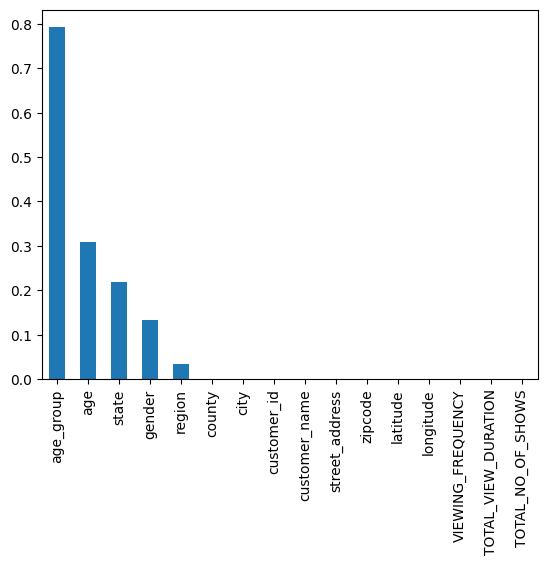

In [22]:
#chi-square test

X = lbl_enc_df.drop('CHURN',axis=1)
y = lbl_enc_df['CHURN']

chi_scores = chi2(X,y)

print('chi_scores =', chi_scores)

#Plotting P-Values

p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

p_values.plot.bar()

#### Droping insignificant Columns based on Chi-Square Test

In [23]:
columns_to_drop = ['age_group', 'age', 'state', 'gender']
lbl_enc_df = lbl_enc_df.drop(columns=columns_to_drop)

#### Save training Data to Snowflake 

In [24]:
# Writing encoded dataframe to Snowflake table
final_table_before_train_test_split = lbl_enc_df
conn_churn.createDataFrame(final_table_before_train_test_split).write.mode('overwrite').save_as_table('Customer_data_for_prediction_modelling') 

## Model Creation

### Train Test Split

In [25]:
#Train-test split 
y_data = lbl_enc_df['CHURN']
x_data = lbl_enc_df.drop('CHURN', axis = 1)
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = 0.3)

In [26]:
training_table = pd.concat([x_training_data, y_training_data], axis=1)
test_table = pd.concat([x_test_data, y_test_data], axis=1)

In [ ]:
# Store train and test split to snowflake tables
# conn_churn.createDataFrame(training_table).write.mode('overwrite').save_as_table('Training_Data')
# conn_churn.createDataFrame(test_table).write.mode('overwrite').save_as_table('Test_Data')

### Model Training and Testing

In [27]:
figsize = (8,5)
def get_rf_model(y_training_data, x_training_data, x_test_data) :
    rf = RandomForestRegressor()
    model = rf.fit(x_training_data,y_training_data)
    
    y_hat = model.predict(x_test_data)
    arr = np.c_[y_hat,y_test_data ]
    # print('\nPrinting predicted and actual values:\n', arr)
    print('\nPrinting Mean Squared Error:\n', (np.sqrt(mean_squared_error(y_test_data,y_hat))))
    print('\nR2 Score:\n', r2_score(y_test_data,y_hat))

    # plot to visualize prediction
    # fix, ax = plt.subplots(figsize = figsize)
    # g = sns.regplot(y=y_test_data, x= y_hat, ax= ax)
    # g.set_xlabel("Predictions", fontsize =15)
    # g.set_ylabel("Test", fontsize = 15)
    # plt.show()

    #Plt.scatter

    # fix, ax = plt.subplots(figsize = figsize)
    # g = sns.regplot(x=y_hat, y= y_test_data-y_hat, color ="red", ax= ax)
    # g.set_xlabel("Predictions", fontsize =15)
    # g.set_ylabel("Test", fontsize = 15)
    # plt.show()

    # Create a scatter plot to compare actual vs. predicted values
    # plt.figure(figsize=figsize)
    # plt.plot(y_test_data, y_hat, alpha=0.5)
    # plt.xlabel("Actual", fontsize=15)
    # plt.ylabel("Predicted", fontsize=15)
    # plt.title("Actual vs. Predicted", fontsize=15)
    # plt.show()

     # Calculate and print the confusion matrix and classification report
    threshold = 0.5  # Set your threshold here
    y_pred_class = (y_hat >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test_data, y_pred_class)
    print('\nConfusion Matrix:\n', conf_matrix)
    
    classification_rep = classification_report(y_test_data, y_pred_class)
    print('\nClassification Report:\n', classification_rep)


    plt.figure(figsize=(6, 4))  # Set the figure size

    # Use seaborn to create a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)

    # Add labels and a title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')


    
    return model, arr, y_hat, conf_matrix, 


Printing Mean Squared Error:
 0.352872564343938

R2 Score:
 0.4356001482595906

Confusion Matrix:
 [[8815 1256]
 [1404 3525]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87     10071
           1       0.74      0.72      0.73      4929

    accuracy                           0.82     15000
   macro avg       0.80      0.80      0.80     15000
weighted avg       0.82      0.82      0.82     15000



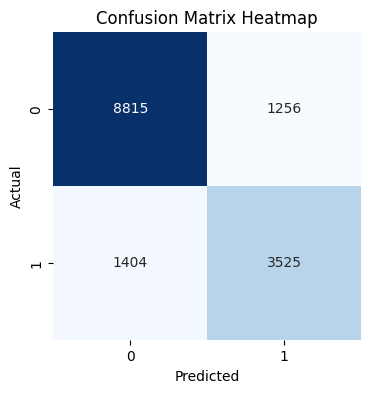

In [28]:
# Model training
model_rf, arr_sm, y_hat, conf_matrix = get_rf_model(y_training_data, x_training_data, x_test_data)

### Adding Predicted Results to snowflake table

In [29]:
predicted_churn = test_table
predicted_churn['Predicted_CHURN']=y_hat
selected_columns = ['customer_id','Predicted_CHURN']
predicted_churn = predicted_churn[selected_columns]
predicted_churn

,customer_id,Predicted_CHURN
35682,35683,0.83
11495,11496,0.97
21535,21536,0.02
31544,31545,0.36
23442,23443,0.30
...,...,...
37217,37218,0.35
46080,46081,0.01
18119,18120,0.43
17475,17476,0.98


In [ ]:
# conn_churn.createDataFrame(predicted_churn).write.mode('overwrite').save_as_table('Predicted_Data')